In [1]:
###
#Demo analysis of the clustering package.
#Within the package, the following algorithms have been implemented:
#
#        - Standard K-Means (KM): 
#            Subcase of KKM with a linear kernel.
#        
#        - Kernel k-Means (KKM): 
#            Clusters in feature space.          
#        
#        - Global Kernel k-Means (GKKM): 
#            kKM with a local search to define initial cluster positions.
#            
#        - Global Kernel k-Means with Convex Mixture Models (GKKM-CMM):
#            optimized boosted version of GkKM to reduce complexity.
#            
#        - Adaptive Weights Clustering (AWC): 
#            A type of adaptive nonparametric clustering.	    
#            
#The present demo evaluates the algorithms performance on the
#UCI sets from the Clustering benchmark datasets page:
#    
#        - https://cs.joensuu.fi/sipu/datasets/
#
###

# Author: Francesco Casola <fr.casola@gmail.com>

In [2]:
# adding the folder to the path
import sys
path_pc = r"../"
sys.path.append(path_pc)
# importing personal package
import clustering as cl

In [10]:
# importing pandas and other modules to handle datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
# os functionalities
import os
#evaluate NMI using the definition in the Efimov paper
from sklearn.metrics import normalized_mutual_info_score as NMI
#performing dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import RandomizedPCA

In [4]:
###
#PART II: The UCI Set
###

In [6]:
#1 - Loading the set
# We select 4 main sets to study the effect of high dimensionality on the clustering algorithms.
# below here a dictionary with the 4 selected datasets

#fields are N,k,D, separator, label column
UCI_set = dict(glass=[214,7,9,',',-1],yeast=[1484,10,8,r"\s+\s+",-1],iris=[150,3,4,',',-1],wdbc=[569,2,31,',',1])

#Loading
path = r"../data/UCI_set"
#dictionary of a set of dataframes
set_dataframes = {}
#gathering and loading fles
for fname in os.listdir(path):
    if fname.endswith('.txt'):
        filename = fname[:-4]
        if filename in UCI_set:
            local_fname = os.path.join(path,fname).replace("\\","/")
            #list of labels
            if UCI_set[filename][-1]==-1:
                names_fields = list(map(str,range(1,UCI_set[filename][2]+1)))+["Labels"]            
            else:
                names_fields = list(map(str,range(1,UCI_set[filename][2]+1)))            
                names_fields.insert(UCI_set[filename][-1],"Labels")
            set_dataframes[fname[:-4]] = pd.read_csv(local_fname,delimiter=UCI_set[filename][3], lineterminator='\n', \
                                           names = names_fields)

In [7]:
#We need to turn labels into numerical format
for set_name in set_dataframes.keys():
    #get the labels
    label_list = list(set(set_dataframes[set_name]['Labels']))
    #new numerical labels
    num_lab = list(range(1,len(label_list)+1))
    #replace values
    set_dataframes[set_name].replace(label_list,num_lab,inplace=True)

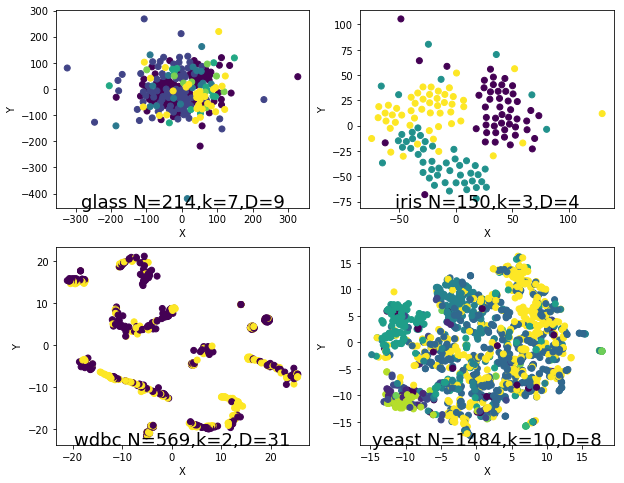

In [19]:
#2a - attempted visualization by performing dimensionality reduction
#As we can see below, TSNE seems to be helping the most in the iris dataset

#dataset names
dts_names = list(set_dataframes.keys())
#dataset size
dt_size = len(dts_names)
#approximating to nearest bigger square
perf_sq = np.arange(1,100)
id_plots = np.where(perf_sq**2>=dt_size)[0]
n_plots = perf_sq[id_plots[0]]

#making the plot
plt.figure(num=1,figsize=(10,8))
for i in range(1, dt_size+1):
    #dimensionality reduction
    tsne_in = TSNE(n_components=2)
    #original dataset - columns
    list_col = list(set_dataframes[dts_names[i-1]].columns.values)
    #remove labels
    list_col.pop(UCI_set[dts_names[i-1]][-1])
    #get dataset
    XX = set_dataframes[dts_names[i-1]].as_matrix(columns=list_col)
    #getting the labels
    real_lab = set_dataframes[dts_names[i-1]].as_matrix(columns=['Labels'])
    #transformed dataset - running tsne
    X_transformed = tsne_in.fit_transform(XX)
    #making the plot
    plt.subplot(n_plots, n_plots, i)     
    ax = plt.scatter(X_transformed[:,0], \
                 X_transformed[:,1], \
                 c=real_lab)
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], dts_names[i-1]+" N=%d,k=%d,D=%d"%tuple(UCI_set[dts_names[i-1]][:3]),
             fontsize=18, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")

Finding optimal solution with 3 clusters.
Finding optimal solution with 3 clusters.


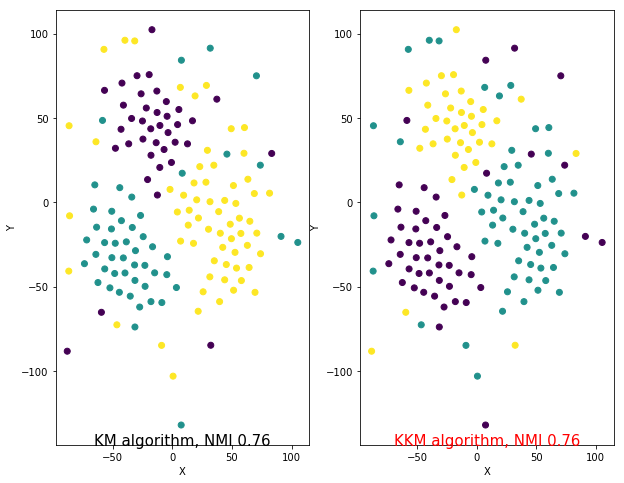

In [16]:
#2b - We make a first comparison between the 2 simplest partitional algorithms: the KM and KKM one.
#We remind the reader that KM is a standard k-means algorithm, and as such it is supposed to work effectively 
#only for linearly separable datasets (i.e. data that can be divided by an hyperplane). 
#To see what this implies and to make a first example of how the clustering package can be used, we run a simple 
#comparison between KM and KKM using the "iris" dataset. As one can see below, KM wants to linearly separate data
#into two classes.

#As one can see below, the NMI looks pretty similar for the two algorithms and the dataset looks linearly separable.

#selected name
sel_name = "iris"
#for this first test, we input how many clusters we expect
n_clusters = UCI_set[sel_name][1]

#loading the iris set
tsne_in = TSNE(n_components=2)
#original dataset - columns
list_col = list(set_dataframes[sel_name].columns.values)
#remove labels
list_col.pop(UCI_set[sel_name][-1])
#get dataset
XX = set_dataframes[sel_name].as_matrix(columns=list_col)
#getting the labels
real_lab = set_dataframes[sel_name].as_matrix(columns=['Labels'])
#transformed dataset - running tsne
X_transformed = tsne_in.fit_transform(XX)
    
#Initializing KM and KKM
KM_means = cl.Cluster_class(algorithm="KM",n_clusters=n_clusters)
KKM_means = cl.Cluster_class(algorithm="KKM",n_clusters=n_clusters,sigm_gauss=5)
    
#Perform the fit in the higher dimensional space   
KM_means.fit(XX)
KKM_means.fit(XX)

#calculate the NMI
NMI_KM = NMI(real_lab.reshape(-1,),KM_means.labels_[n_clusters].reshape(-1,))
NMI_KKM = NMI(real_lab.reshape(-1,),KKM_means.labels_[n_clusters].reshape(-1,))

#plotting the result
plt.figure(num=0,figsize=(10,8))
#plot KM
plt.subplot(1, 2, 1) 
ax = plt.scatter(X_transformed[:,0],X_transformed[:,1],c=KM_means.labels_[n_clusters])
plt.xlabel("X")
plt.ylabel("Y")
loc_ax = np.array(plt.axis())
plt.text(np.mean(loc_ax[:2]),loc_ax[2], 'KM algorithm, NMI %3.2f'%NMI_KM,
         color='black',fontsize=15, ha='center') 
#plot KKM
plt.subplot(1, 2, 2) 
ax = plt.scatter(X_transformed[:,0],X_transformed[:,1],c=KKM_means.labels_[n_clusters])
plt.xlabel("X")
plt.ylabel("Y")
loc_ax = np.array(plt.axis())
plt.text(np.mean(loc_ax[:2]),loc_ax[2], 'KKM algorithm, NMI %3.2f'%NMI_KKM,
         color='red',fontsize=15, ha='center') 

In [21]:
%%capture
#do not show irrelevant output of the calculation

#3a - In this section we want to extensively test the Adaptive Weights Clustering (AWC) algorithm with increasing dimensionality.
# We define a set of parameters lambda spanning several order of magnitude. For each element in this high dimensional dataset, we 
# compute the predicted AWC labels, the NMI and predicted number of clusters.

#values of lambda
list_lambda = [0.001,0.01,0.1,1,10]    

#collecting results
Results_AWC_highD = {}

#loop over datasets
for nm in dts_names:
    #selected name
    sel_name = nm
    #for this first test, we input how many clusters we expect
    n_clusters = UCI_set[sel_name][1]

    #original dataset - columns
    list_col = list(set_dataframes[sel_name].columns.values)
    #remove label column
    list_col.pop(UCI_set[sel_name][-1])
    #get dataset
    XX = set_dataframes[sel_name].as_matrix(columns=list_col)
    #getting the labels
    real_lab = set_dataframes[sel_name].as_matrix(columns=['Labels'])
    
    #saving number of predicted clusters and NMI values
    clust_pred = []
    NMI_val = []
    lab_pred = []

    #loop over lambda values
    for k in list_lambda:
        #Initializing KM and KKM
        AWC_data = cl.Cluster_class(algorithm="AWC",verbose=0,lambda_=k)
        #performing the fit
        AWC_data.fit(XX)
        #saving number of predicted clusters
        clust_pred.append(next(iter(AWC_data.labels_)))
        #saving predicted labels
        lab_predicted = AWC_data.labels_[clust_pred[-1]]
        lab_pred.append(lab_predicted)
        #computing and saving NMI
        NMI_loc = NMI(lab_predicted.reshape(-1,),real_lab.reshape(-1,))
        NMI_val.append(NMI_loc)
    #saving all results for this dataset
    Results_AWC_highD[nm] = [lab_pred,NMI_val,clust_pred]

100% (8 of 8) |##################################################################################################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (8 of 8) |##################################################################################################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (8 of 8) |##################################################################################################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (8 of 8) |##################################################################################################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (8 of 8) |##################################################################################################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (14 of 14) |################################################################################################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (14 of 14) |#############################################################################

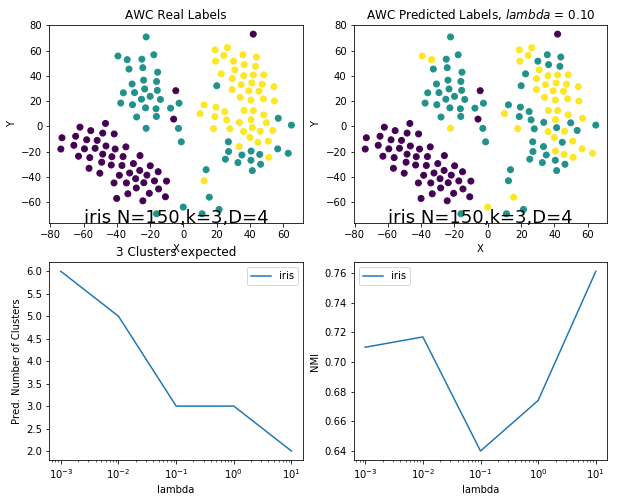

In [49]:
#3b - Here we make representative plots of the results in 3a.
# we will consider e.g. the Iris and the Yeast case as these represent the smallest and the largest number
# of detectable clusters. Here the results for the Iris case.

#selected name
sel_name = "iris"
# lambda selected for scatter plot
lam_sel = 2

#predicted labels
pred_lab = Results_AWC_highD[sel_name][0][lam_sel]


#for this first test, we input how many clusters we expect
n_clusters = UCI_set[sel_name][1]

#loading the iris set
tsne_in = TSNE(n_components=2)
#original dataset - columns
list_col = list(set_dataframes[sel_name].columns.values)
#remove labels
list_col.pop(UCI_set[sel_name][-1])
#get dataset
XX = set_dataframes[sel_name].as_matrix(columns=list_col)
#getting the labels
real_lab = set_dataframes[sel_name].as_matrix(columns=['Labels'])
#transformed dataset - running tsne
X_transformed = tsne_in.fit_transform(XX)

#making the plot
plt.figure(num=1,figsize=(10,8))
plt.subplot(2, 2, 1)     
ax = plt.scatter(X_transformed[:,0],X_transformed[:,1],c=real_lab)
loc_ax = np.array(plt.axis())
plt.text(np.mean(loc_ax[:2]),loc_ax[2], sel_name+" N=%d,k=%d,D=%d"%tuple(UCI_set[sel_name][:3]),
         fontsize=18, ha='center')    
plt.xlabel("X")
plt.ylabel("Y")
plt.title("AWC Real Labels")

plt.subplot(2, 2, 2)     
ax = plt.scatter(X_transformed[:,0],X_transformed[:,1],c=pred_lab)
loc_ax = np.array(plt.axis())
plt.text(np.mean(loc_ax[:2]),loc_ax[2], sel_name+" N=%d,k=%d,D=%d"%tuple(UCI_set[sel_name][:3]),
         fontsize=18, ha='center')    
plt.xlabel("X")
plt.ylabel("Y")
plt.title("AWC Predicted Labels, $lambda$ = %3.2f"%list_lambda[lam_sel])

plt.subplot(2, 2, 3)
k = plt.semilogx(list_lambda,Results_AWC_highD[sel_name][2])
plt.legend(k,[sel_name])
plt.xlabel('lambda')
plt.ylabel('Pred. Number of Clusters')
plt.title("%d Clusters expected"%UCI_set[sel_name][1])

plt.subplot(2, 2, 4)
k = plt.semilogx(list_lambda,Results_AWC_highD[sel_name][1])
plt.legend(k,[sel_name])
plt.xlabel('lambda')
plt.ylabel('NMI')


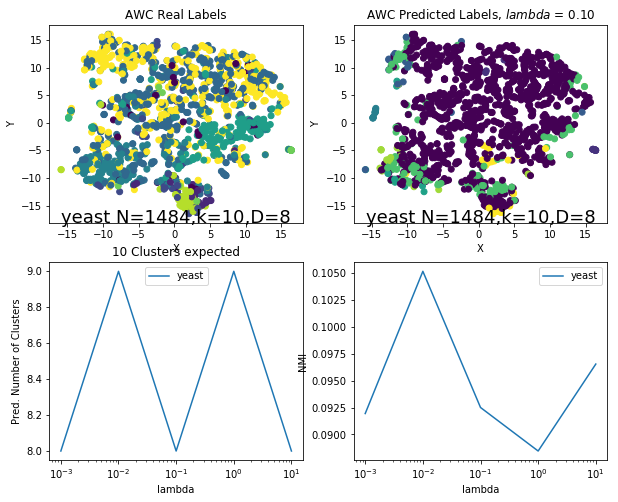

In [50]:
#3d. Here the results for the Yeast case.

#selected name
sel_name = "yeast"
# lambda selected for scatter plot
lam_sel = 2

#predicted labels
pred_lab = Results_AWC_highD[sel_name][0][lam_sel]


#for this first test, we input how many clusters we expect
n_clusters = UCI_set[sel_name][1]

#loading the iris set
tsne_in = TSNE(n_components=2)
#original dataset - columns
list_col = list(set_dataframes[sel_name].columns.values)
#remove labels
list_col.pop(UCI_set[sel_name][-1])
#get dataset
XX = set_dataframes[sel_name].as_matrix(columns=list_col)
#getting the labels
real_lab = set_dataframes[sel_name].as_matrix(columns=['Labels'])
#transformed dataset - running tsne
X_transformed = tsne_in.fit_transform(XX)

#making the plot
plt.figure(num=1,figsize=(10,8))
plt.subplot(2, 2, 1)     
ax = plt.scatter(X_transformed[:,0],X_transformed[:,1],c=real_lab)
loc_ax = np.array(plt.axis())
plt.text(np.mean(loc_ax[:2]),loc_ax[2], sel_name+" N=%d,k=%d,D=%d"%tuple(UCI_set[sel_name][:3]),
         fontsize=18, ha='center')    
plt.xlabel("X")
plt.ylabel("Y")
plt.title("AWC Real Labels")

plt.subplot(2, 2, 2)     
ax = plt.scatter(X_transformed[:,0],X_transformed[:,1],c=pred_lab)
loc_ax = np.array(plt.axis())
plt.text(np.mean(loc_ax[:2]),loc_ax[2], sel_name+" N=%d,k=%d,D=%d"%tuple(UCI_set[sel_name][:3]),
         fontsize=18, ha='center')    
plt.xlabel("X")
plt.ylabel("Y")
plt.title("AWC Predicted Labels, $lambda$ = %3.2f"%list_lambda[lam_sel])

plt.subplot(2, 2, 3)
k = plt.semilogx(list_lambda,Results_AWC_highD[sel_name][2])
plt.legend(k,[sel_name])
plt.xlabel('lambda')
plt.ylabel('Pred. Number of Clusters')
plt.title("%d Clusters expected"%UCI_set[sel_name][1])

plt.subplot(2, 2, 4)
k = plt.semilogx(list_lambda,Results_AWC_highD[sel_name][1])
plt.legend(k,[sel_name])
plt.xlabel('lambda')
plt.ylabel('NMI')